# RandomForest Regressor
Haytham Mohamed

INFS 890 - Spring 2020

In [737]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection, tree
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.2f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [738]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'


#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


test_split = 0.1


In [739]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [740]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.12,0.16,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.40,0.63
1,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.14,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.44,0.62
2,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.15,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.15,0.36,0.62
3,0.09,0.03,0.01,0.02,0.02,0.01,0.01,0.06,0.19,1.00,1.00,1.00,1.00,1.00,1.00,1.54,0.40,0.56
4,0.11,0.04,0.01,0.03,0.03,0.01,0.01,0.11,0.32,1.00,1.00,1.00,1.00,1.00,1.00,2.35,0.78,0.53


In [741]:
data.shape

(1499, 18)

In [742]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 17 features


# Regression with Features Selection

In [743]:
if 1 == 0:
    x_train_select=x_train
    y_train_select=y_train
    x_train_select.shape

In [744]:
# -- trying features selection 1
if 1 == 0:
    selector = feature_selection.SelectKBest(feature_selection.f_regression).fit(x_train_select, y_train_train)
    selectedFeatures = selector.transform(x_train_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))
    

In [745]:
# -- trying features selection 2
if 1 == 0:
    #thresholds = [0.25, 0.01, 0.001]
    max_features=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
    lasso = LassoCV(fit_intercept=False, tol=0.00000000000001,
          max_iter=1000000000, positive=True, cv=10)

    sfm = SelectFromModel(lasso, threshold=-np.inf, max_features=max_features[3]) #(reg, threshold=0.01)

    selectedFeatures = sfm.fit(x_train_select, y_train_select).transform(x_train_select)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))
    

In [746]:
# -- trying features selection 3
if 1 == 0:
    thresholds = ['1*mean', '0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean']
    clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)

    sfm = SelectFromModel(clf,threshold=thresholds[0])

    selectedFeatures = sfm.fit(x_train_select, y_train_select).transform(x_train_select)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))
   

In [747]:
#Features selected
if 1 == 0:
    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train_select[feature_list]
    reduced_x_train.head(2)

# Model

In [748]:
# Regression

# start:  search grid

reg = tree.DecisionTreeRegressor() #(n_estimators=tree_n_estimators, max_features=tree_n_features)

# standardize the features
scaler = StandardScaler()

# features selection
lasso = LassoCV(fit_intercept=False, tol=0.00000000000001,
          max_iter=1000000000, positive=True, cv=10)
sfm = SelectFromModel(lasso, threshold=-np.inf)

# no feastures selection needed for RandomTree Regressor
pipe = Pipeline(steps=[
    ('scaler', scaler),
     ('selector', sfm), 
    ('reg', reg)
])

kfold = KFold(n_splits=2, shuffle=True)

param_grid = {
    #'selector__threshold': ['1*mean', '0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean']
    'selector__max_features': [3, 7, 10, 13, 17]
    #, 'reg__max_depth': [7, 10, 15, 20]
    #, 'reg__max_features': [2, 3, 6, 9, 14, 17]   # The maximum number of features to consider
    #, 'reg__min_samples_split': [10, 20]
    , 'reg__min_samples_leaf': [5]
}


search = GridSearchCV(pipe
                      , param_grid
                      , scoring='neg_mean_squared_error'
                      , return_train_score= True
                      , cv=kfold
                      , verbose=1
                      , n_jobs=-1)

search.fit(x_train, y_train)


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished


GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=LassoCV(alphas=None,
                                                                          copy_X=True,
                                                                          cv=10,
                                                                          eps=0.001,
                                                                          fit_intercept=False,
                                                                          max_iter=1000000000,
                

# Best Model

In [749]:
estimator = search.best_estimator_
params = search.best_params_
score = search.best_score_

print("Best CV score = %0.3f:" % score)
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")
print(all_training_scores['mean_train_score'])

print("")
print('Model training Score = {}'.format(search.score(x_train,y_train)))

Best CV score = -0.017:
Best CV params = {'reg__min_samples_leaf': 5, 'selector__max_features': 17}

[-0.02173678 -0.01159818 -0.00606964 -0.00606964 -0.00534222]

Model training Score = -0.0053054233244549465


# features selected

In [750]:
sfm = pipe['selector']

selectedFeatures = sfm.fit(inputs, targets).transform(inputs)
print('{} features selected'.format(selectedFeatures[1].shape[0]))

feature_list = x_train.columns[sfm.get_support()]
features = ''
features = ', '.join(feature_list)
#features

reduced_x_train = x_train[feature_list]
reduced_x_train.head(2)

17 features selected


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req
0,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.12,0.16,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.40
1,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.14,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.44


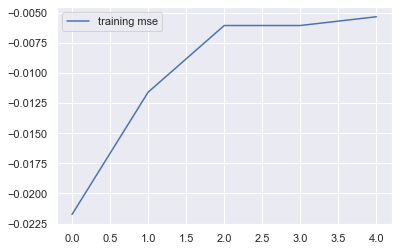

In [751]:
pdf = pd.DataFrame(all_training_scores['mean_train_score'], columns=['training mse'])
pdf.plot()

# Training R2

In [752]:
score = search.score(x_train, y_train)
score

-0.0053054233244549465

In [753]:
#scaler.fit(x_train.values.reshape(-1,n_features))
#x_train = scaler.transform(x_train)

y_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))


R2 (training) = 0.8886272644413131


In [754]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.04 (0.06) 0.00 0.55 MSE


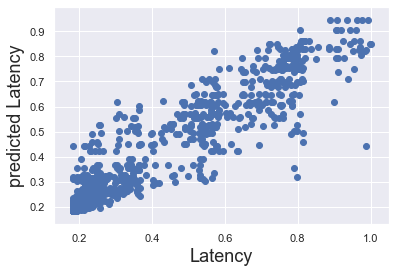

In [755]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

In [756]:
#sns.distplot(y_train - y_hat)
#plt.title('Residual PDF', size=18)

# Testing

In [757]:
y_hat_test = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

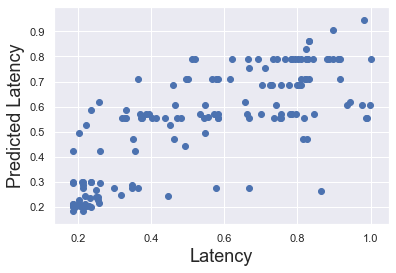

In [758]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

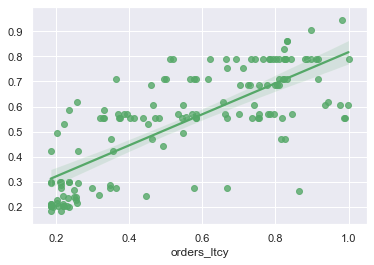

In [759]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [760]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.20,1.20
1,1.28,1.25
2,1.35,1.27
3,1.31,1.28
4,1.27,1.28


In [761]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.20,1.20,-0.00,0.15
1,1.28,1.25,0.03,2.44
2,1.35,1.27,0.08,6.55
3,1.31,1.28,0.02,1.80
4,1.27,1.28,-0.01,0.90
...,...,...,...,...
145,1.77,2.13,-0.36,16.72
146,1.84,2.71,-0.88,32.35
147,2.03,2.50,-0.47,18.66
148,1.74,2.69,-0.95,35.30


In [762]:
perf.describe()

,prediction,target,residual,difference%
count,150.00,150.00,150.00,150.00
mean,1.75,1.79,-0.04,11.98
std,0.35,0.46,0.31,10.94
min,1.20,1.20,-1.07,0.03
25%,1.35,1.30,-0.21,2.95
50%,1.76,1.74,-0.00,8.81
75%,2.03,2.21,0.13,18.65
max,2.57,2.72,0.59,45.06


In [763]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
118,1.77,1.77,0.00,0.03
0,1.20,1.20,-0.00,0.15
31,1.26,1.26,0.00,0.16
131,2.21,2.21,-0.01,0.37
21,1.23,1.23,-0.00,0.37
100,1.75,1.74,0.01,0.43
120,2.29,2.28,0.01,0.46
13,1.22,1.21,0.01,0.53
49,1.60,1.59,0.01,0.61
64,2.21,2.19,0.02,0.69


# Prediction Accuracy

In [764]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.5822516792321049


In [765]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.16703667371318523
